# Mathematical formulation

In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
from utils.utils import (plot_root_intervals, get_max, get_proper_intervals, 
                         plot_predictions)

pd.set_option('display.max_columns', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore the original procedure

In [15]:
#get weights from real clocks (from the first step)
#clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)
clocks = pd.read_csv('clock_data/lin.csv', index_col=0)
method, alpha = 'bonferroni', 0.01
n_corrected_sites = clocks['PearsonP'][multipletests(clocks['PearsonP'], method=method, alpha=alpha)[0]].shape[0]
print(f'Survived after {method} correction {n_corrected_sites} sites at s.level={alpha}')

#get top n from them based on the absolute value of correlation
# top = 5000
# top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
# top_sites = clocks.loc[top_idx]

#get top n/2 positive and n/2 negative from them based on the value of correlation
top = 5000
top_idx_pos = clocks['PearsonR'].sort_values(ascending=False)[:top//2].index
top_idx_neg = clocks['PearsonR'].sort_values(ascending=True)[:top//2].index
top_idx = top_idx_pos.tolist() + top_idx_neg.tolist()
top_sites = clocks.loc[top_idx]

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])
roots_ = -b_ / w_ #polynomial roots before single cell data
dist_ = np.diff(np.sort(roots_))

# make an artificial signle cell methylation data (sampled from binomial distribution)
p_nonmet = 0.5
mask = np.random.binomial(1, p=p_nonmet, size=top).astype(bool)

#change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
roots = -b / w #polynomial roots after single cell data
dist = np.diff(np.sort(roots))

print('Correlation weights and biases before random data', np.round(np.corrcoef(w_, b_)[0,1], 3))
print('Correlation weights and biases after random data', np.round(np.corrcoef(w, b)[0,1], 3))
print('Median distance between roots before random data:', np.round(np.median(dist_), 3))
print('Median distance between roots after random data:', np.round(np.median(dist), 3))

Survived after bonferroni correction 815 sites at s.level=0.01
Correlation weights and biases before random data -0.269
Correlation weights and biases after random data -0.21
Median distance between roots before random data: 0.014
Median distance between roots after random data: 0.067


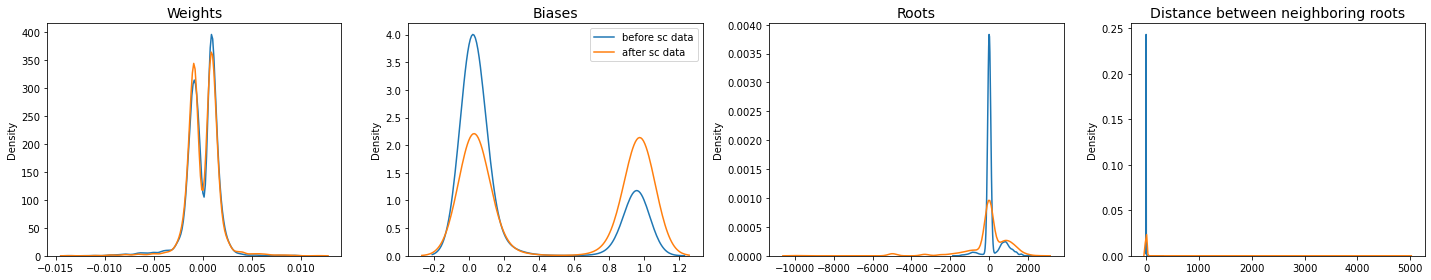

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].set_title('Weights', fontsize=14)
sns.kdeplot(w_, label='before sc data', ax=axes[0])
sns.kdeplot(w, label='after sc data', ax=axes[0])

axes[1].set_title('Biases', fontsize=14)
sns.kdeplot(b_, label='before sc data', ax=axes[1])
sns.kdeplot(b, label='after sc data', ax=axes[1])

axes[2].set_title('Roots', fontsize=14)
sns.kdeplot(roots_, label='before sc data', ax=axes[2])
sns.kdeplot(roots, label='after sc data', ax=axes[2])

axes[3].set_title('Distance between neighboring roots', fontsize=14)
sns.kdeplot(dist_, label='before sc data', ax=axes[3])
sns.kdeplot(dist, label='after sc data', ax=axes[3])

axes[1].legend()
plt.tight_layout()
plt.show()

**Conclusion:** Number of steps should be at least **10 times higher** than median distance between roots (but no guarantees).

* if left boundary of site > right boundary of search interval, $p \approx 1$
* if right boundary of site < left boundary of search interval, $p \approx 0$

Corrected interval: (2.692539682539669, 16.99)


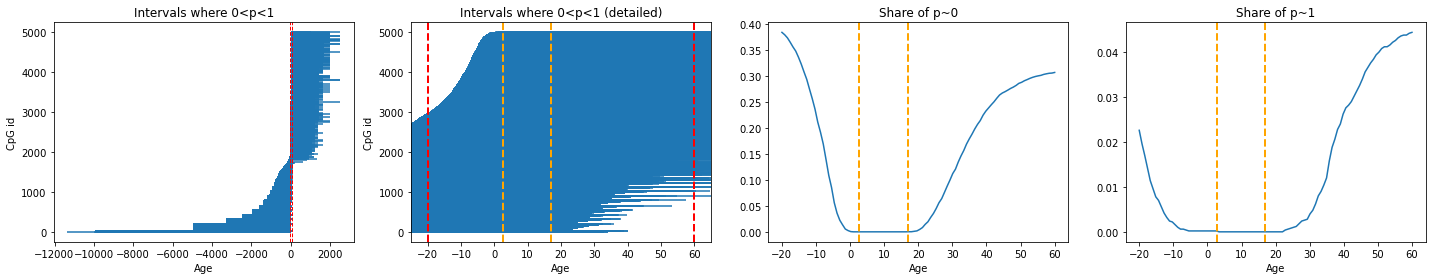

In [17]:
interval_of_search = (-20, 60)
plot_root_intervals(w_, b_, interval_of_search=interval_of_search) #if all CpG are 1

Corrected interval: (2.692539682539669, 16.989999999999792)


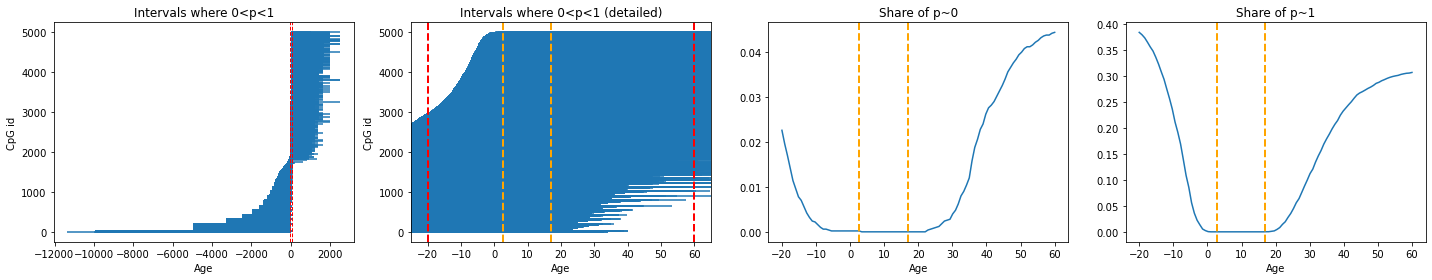

In [18]:
plot_root_intervals(-w_, 1-b_, interval_of_search=interval_of_search) #if all CpG are 0

Corrected interval: (2.692539682539669, 16.989999999999792)


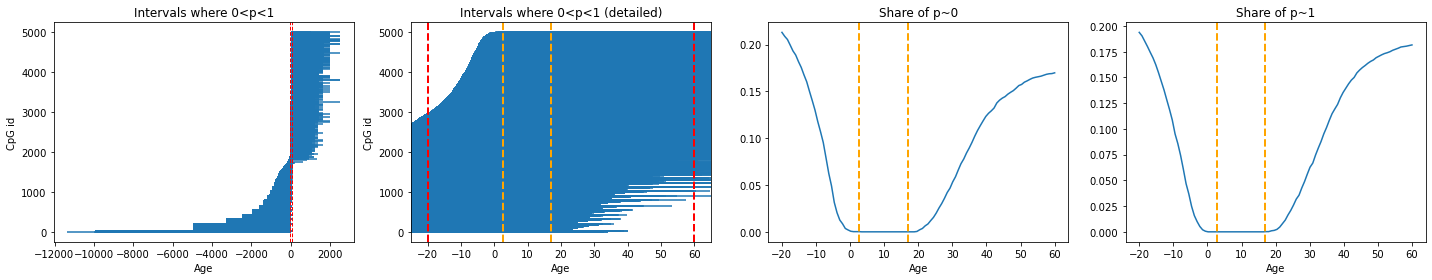

In [19]:
plot_root_intervals(w, b, interval_of_search=interval_of_search) #if half CpG are 0

**Conclusion:** Proper interval should be used, where probabilities don't turn into boundary constants.

### Single cell artificial data

In [20]:
n_steps = 1000
m_cells = 100
interval_of_search = (-20, 50)
one_met_replacement = 0.999
zero_met_replacement = 0.001

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

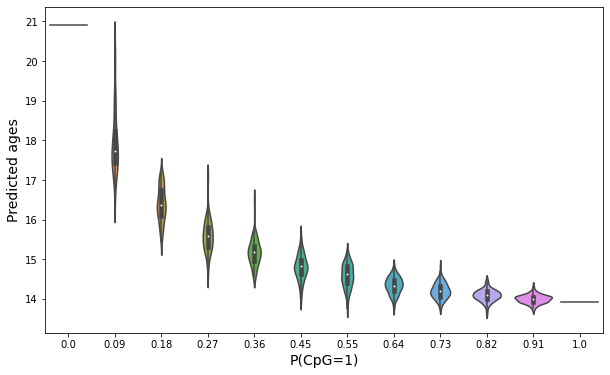

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

In [42]:
# with proper interval
n_steps = 1000
m_cells = 100

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
proper_intervals = get_proper_intervals(w_, b_)
interval_of_search = (proper_intervals[:, 0].max() + eps, proper_intervals[:, 1].min() - eps)

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p = np.where(mask, p, 1-p)
            assert ~(p <= 0).any() or ~(p >= 1).any(), "Inproper interval found!"
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

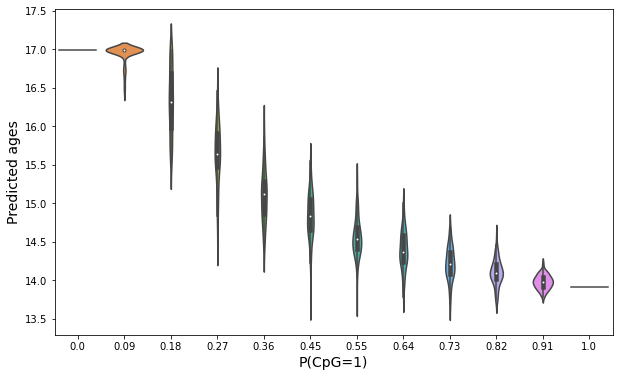

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

Here we reproduce the original procedure and obtain cell age prediction in different datasets.

In [62]:
### CHOOSE THE DATASET from {embryo, liver, muscle}
dataset = 'liver'

if dataset == 'embryo':
    #embryogenesis
    meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.1.developmental stage']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/cells/*.h5')
    file_format = '.h5'
    gse_id = 'GSE121690_cells'
    box_pairs = [('E4.5', 'E5.5'), 
                 ('E5.5', 'E6.5'),
                 ('E6.5', 'E7.5')
                ]
elif dataset == 'liver':
    #liver aging
    meta = pd.read_csv('cell_data/SRA344045_metadata.tsv', index_col=0, sep='\t')
    meta['stage'] = meta['Tissue-Age']
    stages = sorted(meta['stage'].unique().tolist())[::-1]
    list_cells = glob('cell_data/SRA344045_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'SRA344045_cells'
    box_pairs = [('MEF', 'Hepatocyte\n(4 month)'), 
                 ('Hepatocyte\n(4 month)', 'Hepatocyte\n(26 month)'),
                ]
elif dataset == 'muscle':
    #muscle stem cell aging
    meta = pd.read_csv('cell_data/GSE121436_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.2.age']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/GSE121436_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'GSE121436_cells'
    box_pairs = [('2 months', '24 months')]
else:
    raise NotImplementedError('No such dataset')

In [47]:
# Cell age inference
######
n_steps = 1000
interval_of_search = (-20, 50) #CUSTOM INTERVAL IN SCOPE
######
one_met_replacement = 0.999
zero_met_replacement = 0.001
######

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    skip_counter = 0
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        ### read data ###
        path = f'cell_data/{gse_id}/{cell_name}{file_format}'
        assert os.path.exists(path)
        if file_format == '.h5':
            cell_df = pd.read_hdf(path)
        elif file_format == '.tsv':
            cell_df = pd.read_csv(path, sep='\t', index_col=0)
            
        ### filter data ###
        #coverage check
        if cell_df.shape[0] < 500_000: 
            skip_counter += 1
            continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0: 
            skip_counter += 1
            #print('No common')
            continue
            
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites].iloc[:, 0].values
        global_methylation = np.mean(cell_df.iloc[:, 0].values)
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(global_methylation)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])
    print("Skipped:", skip_counter)

100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Skipped: 0


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Skipped: 2


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

Skipped: 0


In [81]:
data['trueAge'] = data['Stage'].map({'MEF':0, 'Hepatocyte\n(4 month)':4, 'Hepatocyte\n(26 month)':26})
print('R2 =', round(np.corrcoef(data['Ages'], data['trueAge'])[0, 1]**2, 3))

R2 = 0.445


In [86]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').mean()

Stage
Hepatocyte\n(26 month)    10
Hepatocyte\n(4 month)      9
MEF                        5
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell,trueAge
Stage,,,,,
Hepatocyte\n(26 month),16.884885,420.900000,0.225660,0.676605,26.0
Hepatocyte\n(4 month),4.789234,277.444444,0.222699,0.684471,4.0
MEF,4.384384,840.200000,0.206036,0.634999,0.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEF v.s. Hepatocyte
(4 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.100e+01
Hepatocyte
(4 month) v.s. Hepatocyte
(26 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.593e-02 U_stat=1.200e+01


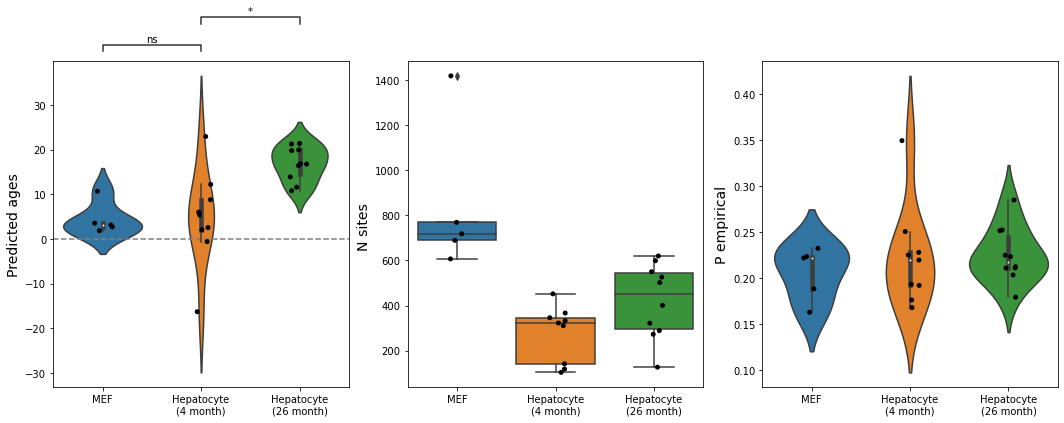

In [87]:
plot_predictions(data, 
                box_pairs=box_pairs,
                )

Now let's change the arbitrary interval with proper one.

In [88]:
#PROPER INTERVAL IN SCOPE
w_, b_ = top_sites['Coef'].values, top_sites['Intercept'].values
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
proper_intervals = get_proper_intervals(w_, b_)
interval_of_search = (proper_intervals[:, 0].max() + eps, proper_intervals[:, 1].min() - eps)
############

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    skip_counter = 0
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        ### read data ###
        path = f'cell_data/{gse_id}/{cell_name}{file_format}'
        assert os.path.exists(path)
        if file_format == '.h5':
            cell_df = pd.read_hdf(path)
        elif file_format == '.tsv':
            cell_df = pd.read_csv(path, sep='\t', index_col=0)
            
        ### filter data ###
        #coverage check
        if cell_df.shape[0] < 500_000: 
            skip_counter += 1
            continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0: 
            skip_counter += 1
            #print('No common')
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites].iloc[:, 0].values
        global_methylation = np.mean(cell_df.iloc[:, 0].values)
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            if (p <= 0).any() or (p >= 1).any(): 
                p[p <= 0] = zero_met_replacement
                p[p >= 1] = one_met_replacement
                print('oops!')
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(global_methylation)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [89]:
data['trueAge'] = data['Stage'].map({'MEF':0, 'Hepatocyte\n(4 month)':4, 'Hepatocyte\n(26 month)':26})
print('R2 =', round(np.corrcoef(data['Ages'], data['trueAge'])[0, 1]**2, 3))

R2 = 0.638


In [90]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').mean()

Stage
Hepatocyte\n(26 month)    10
Hepatocyte\n(4 month)      9
MEF                        5
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell,trueAge
Stage,,,,,
Hepatocyte\n(26 month),15.447191,420.900000,0.225660,0.676605,26.0
Hepatocyte\n(4 month),6.685524,277.444444,0.222699,0.684471,4.0
MEF,4.550208,840.200000,0.206036,0.634999,0.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEF v.s. Hepatocyte
(4 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.900e+01
Hepatocyte
(4 month) v.s. Hepatocyte
(26 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.615e-03 U_stat=1.000e+01


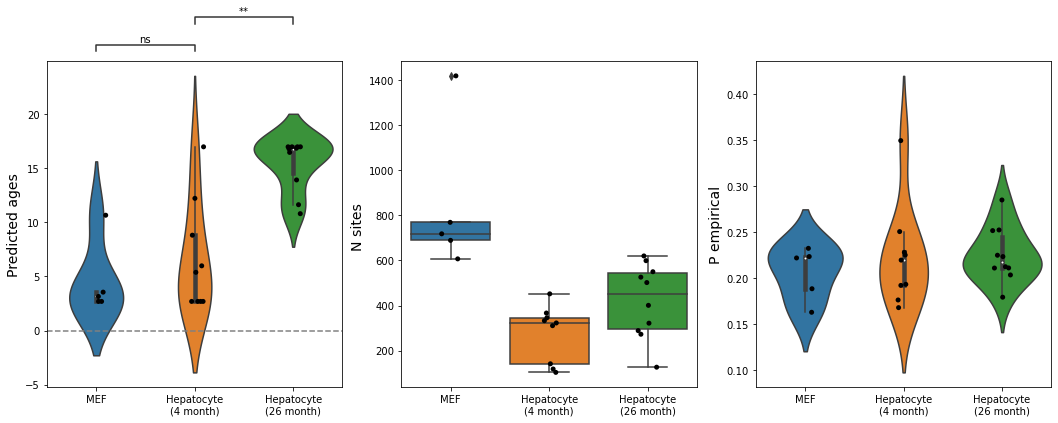

In [91]:
plot_predictions(data, 
                box_pairs=box_pairs,
                )

# Correct procedure

### Artificial data

In [413]:
m_cells = 100
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print("Correct interval:", interval_of_search)

data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0., 1.0, 12):
    x_opt = np.zeros(m_cells)
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        x_opt[cell] = get_max(w, b, domain=interval_of_search, verbose=0, proper_interval=True)

    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

Correct interval: (2.525556585750008, 25.707286335607854)


/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not makin

In [415]:
data

,Ages,p
0,5.957151,0.0
1,5.957151,0.0
2,5.957151,0.0
3,5.957151,0.0
4,5.957151,0.0
...,...,...
95,2.525557,1.0
96,2.525557,1.0
97,2.525557,1.0
98,2.525557,1.0


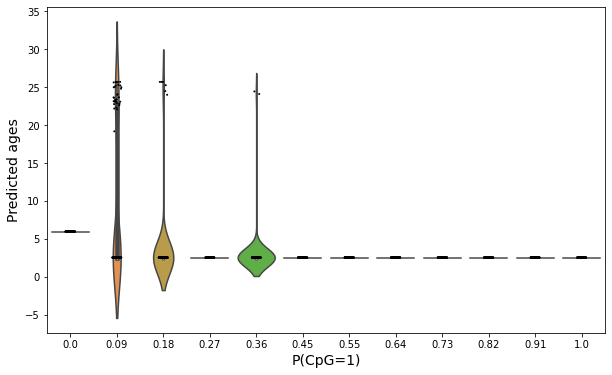

In [414]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
sns.stripplot(x='p', y='Ages', data=data, ax=axes, color='black', s=2)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

*Question*: Ground zero in radnom data???

### Real data

In [416]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
############

data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        predicted_age = get_max(w, b, domain=interval_of_search, verbose=0)
        
        cell_ages.append(predicted_age)
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

 18%|█▊        | 24/133 [00:12<01:17,  1.41it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 20%|█▉        | 26/133 [00:14<01:22,  1.29it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 21%|██        | 28/133 [00:16<01:37,  1.08it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 24%|██▍       | 32/133 [00:18<00:47,  2.14it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
 26%|██▌       | 34/133 [00:20<01:05,  1.52it/s]/tmp/ipykernel_10756/2792648049.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) f

In [417]:
data.groupby('Stage').mean()

,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,11.855237,153.053191,0.070187,0.273517
E5.5,6.845827,165.990099,0.139623,0.682844
E6.5,9.596447,239.068966,0.137962,0.745636
E7.5,8.725912,276.793548,0.120269,0.747040


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.485e-07 U_stat=6.758e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.527e-01 U_stat=6.596e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.545e-01 U_stat=1.196e+04


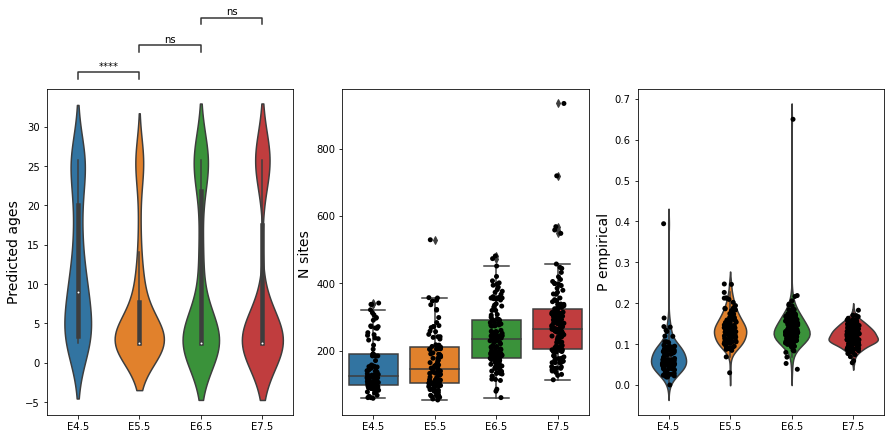

In [418]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

Conclusion: I see ground zero after my procedure.

# Other

In [408]:
def get_max(w, b, domain=None, verbose=0, proper_interval=True):
    """
    Get maxium of Likelihood by checking each concave part of polynimial
    likelihood separately.
    
    Params:
    w - weights of CpGs from reference data
    b - biases of CpGs from reference data
    domain - interval of search
    verbose - if print the information about whether the solution was on the boundary of the interval
    proper_interval - if domain includes ages where p < 0 or p > 1, then do not use log-likelihood
    and use direct product instead

    Return: optimal age
    """
    roots = -b / w
    ord = 'even' if (len(roots) % 2) == 0 else 'odd'
    sign = np.prod(np.sign(w))
    roots = np.sort(roots)
    domain = [roots[0], roots[-1]] if domain is None else domain

    if proper_interval:
        ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
    else:
        ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
    df = lambda x: np.sum([wi/(wi*x + bi) for wi, bi in zip(w, b)])

    if (ord == 'even') and (sign > 0): #first root left from min; last root right from min
        pairs = roots[1:-1].reshape(-1, 2).tolist()
    elif (ord == 'even') and (sign < 0): #first root left from max; last root right from max
        pairs = roots.reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign > 0): #first root left from max; last root right from min
        pairs = roots[:-1].reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign < 0): #first root left from min; last root right from max
        pairs = roots[1:].reshape(-1, 2).tolist()
        
    maxroots = []
    for pair in pairs:
        #if (pair[1] < domain[0]) or (pair[0] > domain[1]): continue
        if pd.Interval(*domain).overlaps(pd.Interval(*pair)):
            root = fsolve(df, np.mean(pair))[0]
            #print(root)
        else:
            continue
        if (domain[0] <= root <= domain[1]): #maximum must be within the interval
            maxroots.append(root)
    
    maxroots = [domain[0]] + maxroots + [domain[1]] # check interval boundaries
    solution = maxroots[np.argmax([ff(m) for m in maxroots])]
    if verbose > 0:
        if (solution == maxroots[0]):
            print('Solution on the start of the interval!')
        elif solution == maxroots[-1]:
            print('Solution on the end of the interval!')
        else:
            pass
    return solution

10.57889732054429
My procedure: 10.57889732054429
Numerically: []

23.74929954685503
23.74929954685503
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


27.29421186522698
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


41.928166788089875
26.042613090061046
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


40.043680156470465
My procedure: 24
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


25.353233896195707
28.651064042266206
29.616696003031034
46.35929293724842
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


29.335322697402635
56.35650050315699
25.11260210183885
31.743510013575882
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


35.70418544803957
29.630896585476183
26.49870861067009
27.186483783278618
21.43770466804567
28.657757769645688
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


3.034921435761842
48.63261020108766
28.655992799677605
50.45302479311479
24.148168912558187
25.493788854649583
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])


22.567206038352257


/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


19.324633380097886
26.25091914330102
30.345010683159284
22.141297761612996
24.143509453069623
My procedure: 3
Numerically: []



/tmp/ipykernel_10756/3425978285.py:23: RuntimeWarning: invalid value encountered in log
  ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
/home/shappiron/anaconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


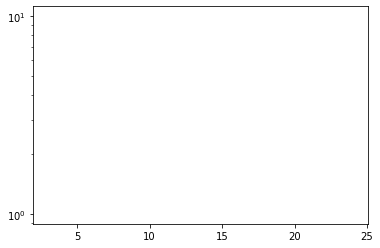

In [405]:
from scipy.signal import argrelextrema

n = 5000 #number of weights
after_data = True
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:n].index
top_sites_test = clocks.loc[top_idx]

interval_of_search = (3, 24)
w_ = np.asarray(top_sites_test['Coef'])
b_ = np.asarray(top_sites_test['Intercept'])

for p_nonmet in np.arange(0.01, 1.0, 0.1):
    if after_data:
        # make an artificial signle cell methylation data (sampled from binomial distribution)
        p_nonmet = p_nonmet
        mask = np.random.binomial(1, p=p_nonmet, size=n).astype(bool)

        #change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
        # w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
        # b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        roots = -b / w #polynomial roots after single cell data
        dist = np.diff(np.sort(roots))
    else: 
        w = w_.copy()
        b = b_.copy()

    ff = lambda x: np.prod([(wi_*x + bi_) for wi_, bi_ in zip(w, b)])
    z = np.linspace(interval_of_search[0], interval_of_search[1], 1000)
    fz = [ff(zi) for zi in z]


    extrema = argrelextrema(np.array(fz), np.greater, mode='wrap')[0]
    num_max = z[extrema]
    num_max = [z[0], num_max, z[-1]][np.argmax([ff(z[0]), ff(num_max), ff(z[-1])])] #include boundaries

    print("My procedure:", get_max(w, b, domain=interval_of_search, proper_interval=True))
    print("Numerically:", num_max)
    print()

    plt.semilogy(z, fz);